  x        u(x)           estimated error
 -1.00       0.00000000        0.0e+00
 -0.80      -0.05955510        8.6e-10
 -0.60      -0.09636217        3.5e-10
 -0.40      -0.09636217        3.5e-10
 -0.20      -0.05955510        8.6e-10
  0.00       0.00000000        6.5e-27
  0.20       0.05955510        8.6e-10
  0.40       0.09636217        3.5e-10
  0.60       0.09636217        3.5e-10
  0.80       0.05955510        8.6e-10
  1.00       0.00000000        0.0e+00


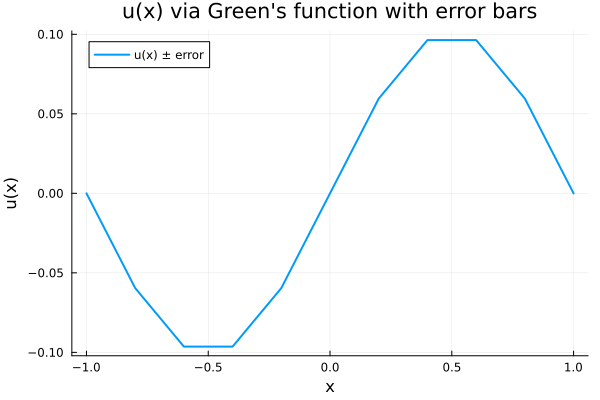

In [23]:
using QuadGK
using Plots
using Printf

# Define the source function f(y)
f(y) = sin(pi * y)

# Define the Green's function kernel k(x, y)
function k(x, y)
    if x < y
        return 0.5 * (1 - y) * (x + 1)
    else
        return 0.5 * (1 + y) * (1 - x)
    end
end

# Compute u(x) = ∫ k(x, y) f(y) dy with error estimate
function u_and_error(x)
    integrand(y) = k(x, y) * f(y)
    val, err = quadgk(integrand, -1.0, 1.0)
    return val, err
end

# Sample x and collect values
x_vals = -1:0.2:1  
u_vals = Float64[]
u_errs = Float64[]

println("  x        u(x)           estimated error")
println("==========================================")
for x in x_vals
    val, err = u_and_error(x)
    push!(u_vals, val)
    push!(u_errs, err)
    @printf("%6.2f   %14.8f   %12.1e\n", x, val, err)
end

# Optional: plot with error ribbon
plot(x_vals, u_vals,
     ribbon = u_errs,
     label = "u(x) ± error",
     xlabel = "x",
     ylabel = "u(x)",
     title = "u(x) via Green's function with error bars",
     lw = 2)

In [24]:
u_and_error(0.1)

(0.03130996766023503, 1.1294772079694249e-10)

In [25]:
f(0.1)

0.3090169943749474

In [26]:
using LinearAlgebra
using Plots

# Define the target function
A(x, y) = cos(x * sin(y))

A (generic function with 1 method)

In [27]:
# Create a grid of points
x_vals = range(-1, 1, length=5)
y_vals = range(-1, 1, length=5)

points = [(x, y) for x in x_vals, y in y_vals]
points = vec(points)  # flatten 2D to 1D vector of tuples

N = length(points)

25

In [ ]:
# Helper: Generate all monomial powers (i, j) such that i + j ≤ d
function monomial_powers_2d(degree::Int)
    powers = []
    for i in 0:degree
        for j in 0:(degree - i)
            push!(powers, (i, j))
        end
    end
    return powers
end

# Construct Vandermonde matrix
function build_vandermonde(points::Vector{Tuple{Float64,Float64}}, degree::Int)
    powers = monomial_powers_2d(degree)
    V = zeros(length(points), length(powers))
    for (row, (x, y)) in enumerate(points)
        for (col, (i, j)) in enumerate(powers)
            V[row, col] = x^i * y^j
        end
    end
    return V, powers
end

V, powers = build_vandermonde(points, 5)  # total degree ≤ 2

([1.0 -1.0 … 1.0 1.0; 1.0 -1.0 … 0.001953125 0.0009765625; … ; 1.0 1.0 … 0.001953125 0.0009765625; 1.0 1.0 … 1.0 1.0], Any[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)  …  (7, 0), (7, 1), (7, 2), (7, 3), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (10, 0)])

In [ ]:
# Evaluate function at grid points
b = [A(x, y) for (x, y) in points]

# Solve V * c = b
c = V \ b

25-element Vector{Float64}:
 0.6663667453928805
 0.9127887886561931
 1.0
 0.9127887886561931
 0.6663667453928805
 0.8872600507176526
 0.9714062102739648
 1.0
 0.9714062102739648
 0.8872600507176526
 ⋮
 0.9714062102739648
 1.0
 0.9714062102739648
 0.8872600507176526
 0.6663667453928805
 0.9127887886561931
 1.0
 0.9127887886561931
 0.6663667453928805

In [30]:
function evaluate_poly(x, y, c, powers)
    result = 0.0
    for (coeff, (i, j)) in zip(c, powers)
        result += coeff * x^i * y^j
    end
    return result
end

evaluate_poly (generic function with 1 method)

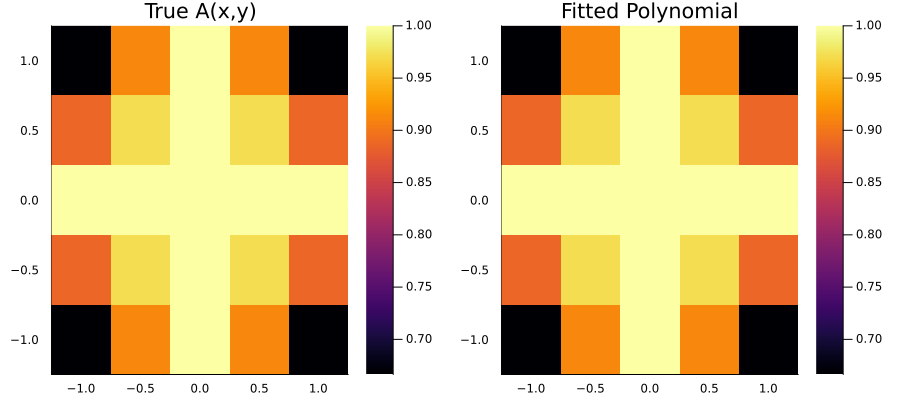

In [31]:
x_grid = range(-1,1,5)
y_grid = range(-1,1,5)

Z_true = [A(x, y) for x in x_grid, y in y_grid]
Z_fit  = [evaluate_poly(x, y, c, powers) for x in x_grid, y in y_grid]

plot(
    heatmap(x_grid, y_grid, Z_true', title="True A(x,y)"),
    heatmap(x_grid, y_grid, Z_fit', title="Fitted Polynomial"),
    layout=(1, 2), size=(900, 400)
)

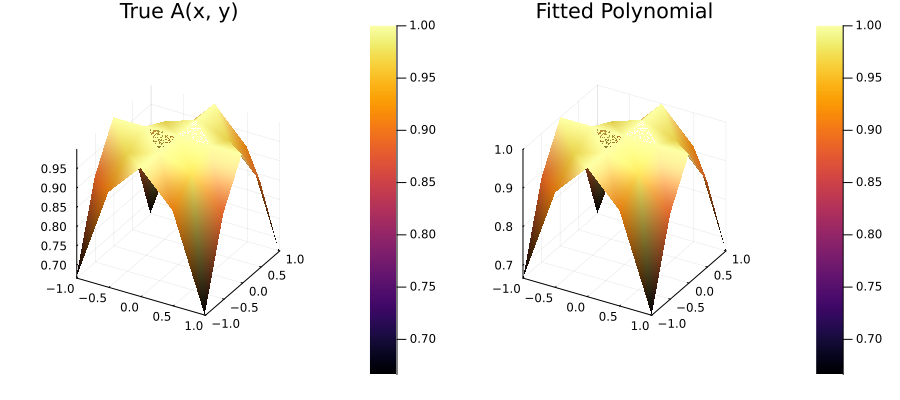

In [32]:
# Surface plot of both functions side by side
plot(
    surface(x_grid, y_grid, Z_true', title="True A(x, y)"),
    surface(x_grid, y_grid, Z_fit', title="Fitted Polynomial"),
    layout=(1, 2), size=(900, 400)
)

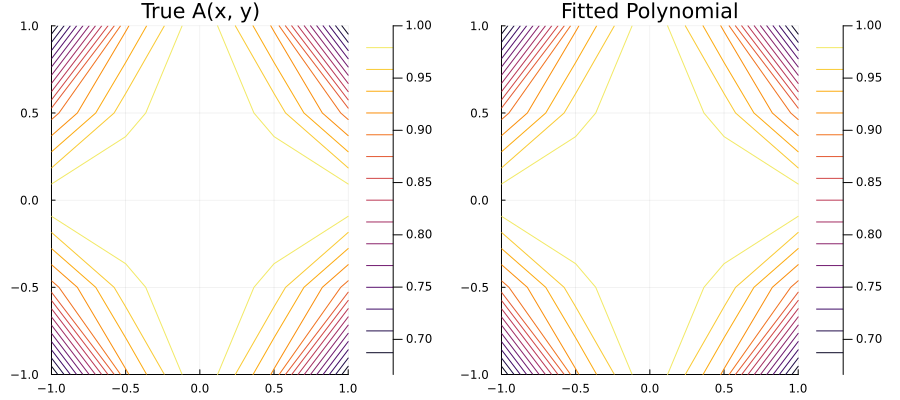

In [33]:
# Contour plots (top-down view)
plot(
    contour(x_grid, y_grid, Z_true', title="True A(x, y)"),
    contour(x_grid, y_grid, Z_fit', title="Fitted Polynomial"),
    layout=(1, 2), size=(900, 400)
)

Least Squares Regression

In [ ]:
using Plots
x_grid = range(-1,1,100)
y_grid = range(-1,1,100)
least_squares_points = [(x,y) for x in x_grid, y in y_grid]
b = [A(x, y) for (x, y) in vec(least_squares_points)]
V, powers = build_vandermonde(vec(least_squares_points), 10)
c = V \ b
Z_true = [A(x, y) for x in x_grid, y in y_grid]
plot(
    surface(x_grid, y_grid, Z_true', title="True A(x, y)"),
    surface(x_grid, y_grid, V*c, title = "Least Squares Approximation"),
    layout=(1, 2), size=(900, 400)
    )